# Imports and Configuration

In [103]:
import zipfile
import os
import shutil

zip_file_path = 'pickleball_shots.zip'
extract_dir = '.'  # Extract to current directory

# Remove existing directory if it exists to ensure a clean overwrite
if os.path.exists('pickleball_shots'):
    print(f"Removing existing 'pickleball_shots' directory...")
    shutil.rmtree('pickleball_shots')

if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"'{zip_file_path}' unzipped successfully to '{extract_dir}'.")
else:
    print(f"Error: '{zip_file_path}' not found.")

Removing existing 'pickleball_shots' directory...
'pickleball_shots.zip' unzipped successfully to '.'.


In [104]:

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

print(f"TensorFlow Version: {tf.__version__}")

# --- CONFIGURATION ---
NUM_PICKLEBALL_CLASSES = 3  # serve, forehand, backhand
INPUT_SHAPE = (30, 26)      # 30 frames, 26 features
DATA_FOLDER = 'pickleball_shots' # Name of folder with your CSVs
MODEL_PATH = 'primary_tennis_model.h5'


TensorFlow Version: 2.19.0


# Data Loading

In [105]:
def load_pickleball_data(data_folder, input_shape=(30, 26)):
    """
    Loads Pickleball CSVs recursively from all subfolders, excluding 'neutral' shots.
    """
    sequences = []
    labels = []

    # Different types of tennis shots
    label_map = {
        'serve': 0,
        'forehand': 1,
        'backhand': 2
        # 'neutral' is excluded
    }

    if not os.path.exists(data_folder):
        print(f"ERROR: Folder {data_folder} not found.")
        return np.array([]), np.array([])

    csv_files_found = 0

    #
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            if file.endswith('.csv'):
                csv_files_found += 1
                file_path = os.path.join(root, file)

                # 1. Read CSV
                try:
                    df = pd.read_csv(file_path)
                    features = df.iloc[:, :-1].values
                except Exception as e:
                    continue # Skip broken files

                # 2. Extract Label from filename
                # Files like "neutral_001.csv" -> "neutral"
                label_str = file.split('_')[0].lower()

                if label_str not in label_map: # This will now skip 'neutral' and any other unmapped labels
                    # print(f"Skipped {file} (Label '{label_str}' not in map)") # Uncomment for debugging skipped files
                    continue

                # 3. Handle Time Dimension (Pad/Truncate)
                current_frames = features.shape[0]
                target_frames = input_shape[0]

                if current_frames == 0:
                    continue

                if current_frames > target_frames:
                    features = features[:target_frames, :]
                elif current_frames < target_frames:
                    padding_needed = target_frames - current_frames
                    last_row = features[-1, :]
                    padding = np.tile(last_row, (padding_needed, 1))
                    features = np.vstack((features, padding))

                sequences.append(features)
                labels.append(label_map[label_str])

    print(f"Scanned {csv_files_found} CSV files. Loaded {len(sequences)} valid samples.")
    return np.array(sequences), np.array(labels)

# Load and Build the Models

Load Pre-trained Tennis Model

In [106]:
# Check if model exists
if os.path.exists(MODEL_PATH):
    print("Loading Tennis Model...")

    # Custom LSTM class to handle 'time_major' errors from older Keras versions
    class CustomLSTM(tf.keras.layers.LSTM):
        def __init__(self, **kwargs):
            kwargs.pop('time_major', None)
            super().__init__(**kwargs)

    try:
        base_model = tf.keras.models.load_model(MODEL_PATH, custom_objects={'LSTM': CustomLSTM})
        print("Base model loaded successfully.")
    except Exception as e:
        print(f"CRITICAL ERROR: Failed to load model: {e}")
else:
    print(f"CRITICAL ERROR: {MODEL_PATH} not found. Please upload it to Colab files.")

Loading Tennis Model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Base model loaded successfully.


Model Building Function

In [107]:
def build_transfer_model(base_model, num_classes, input_shape):
    # Ensure base_model is built
    if not base_model.built:
        base_model.build(input_shape=(None,) + input_shape)

    # Freeze the base model layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Find the output layer of the feature extractor
    # We look for 'dropout_5' or fall back to an index near the end
    try:
        base_output = base_model.get_layer('dropout_5').output
    except ValueError:
        print("Layer 'dropout_5' not found, using 4th to last layer.")
        base_output = base_model.layers[-4].output

    # Add new Classification Head for Pickleball
    x = layers.Dense(64, activation='relu', name='pickle_dense')(base_output)
    x = layers.Dropout(0.3, name='pickle_dropout')(x)
    predictions = layers.Dense(num_classes, activation='softmax', name='pickle_output')(x)

    transfer_model = models.Model(inputs=base_model.inputs[0], outputs=predictions)
    return transfer_model

# Load Data and Create Model

In [108]:
# 1. LOAD DATA
print(f"Loading data from '{DATA_FOLDER}'...")
X, y = load_pickleball_data(DATA_FOLDER, input_shape=INPUT_SHAPE)

if X.size == 0:
    raise ValueError(f"CRITICAL ERROR: No data found in '{DATA_FOLDER}'. Check folder name and contents.")

# 2. SPLIT DATA
# stratify=y ensures we keep the same balance of shots in train and val
X_train_raw, X_val_raw, y_train_indices, y_val_indices = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # Temporarily removed due to insufficient samples per class
)

# 3. NORMALIZE DATA
scaler = StandardScaler()

# Flatten 3D -> 2D for scaling
X_train_flat = X_train_raw.reshape(-1, X_train_raw.shape[-1])
X_val_flat = X_val_raw.reshape(-1, X_val_raw.shape[-1])

# Fit on TRAIN only, transform both
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_val_scaled_flat = scaler.transform(X_val_flat)

# Reshape back to 3D
X_train = X_train_scaled_flat.reshape(X_train_raw.shape)
X_val = X_val_scaled_flat.reshape(X_val_raw.shape)

# 4. ONE-HOT ENCODE LABELS
y_train = to_categorical(y_train_indices, num_classes=NUM_PICKLEBALL_CLASSES)
y_val = to_categorical(y_val_indices, num_classes=NUM_PICKLEBALL_CLASSES)

print(f"Training Data: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation Data: {X_val.shape}, Labels: {y_val.shape}")

# 5. BUILD MODEL
print("\nBuilding Pickleball Model...")
pickle_model = build_transfer_model(base_model, NUM_PICKLEBALL_CLASSES, INPUT_SHAPE)

# Compile for Phase 1
pickle_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Ready.")

Loading data from 'pickleball_shots'...
Scanned 206 CSV files. Loaded 98 valid samples.
Training Data: (78, 30, 26), Labels: (78, 3)
Validation Data: (20, 30, 26), Labels: (20, 3)

Building Pickleball Model...
Model Ready.


Class Weighting

(The system tried to cheat and guess neutral everytime)

In [109]:
from sklearn.utils import class_weight

# Calculate weights based on training data
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_indices),
    y=y_train_indices
)

# Convert to dictionary format required by Keras
class_weights_dict = dict(enumerate(class_weights_vals))

print("Class Weights:", class_weights_dict)
# You will likely see something like: {0: 2.5, 1: 2.5, 2: 2.5, 3: 0.4}
# This means "Neutral" (3) is less important, and others are 2.5x more important.

Class Weights: {0: np.float64(1.4444444444444444), 1: np.float64(0.7428571428571429), 2: np.float64(1.04)}


# Training

Warmup

In [110]:
print("--- Starting Phase 1: Warm Up (Head Only) ---")

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history_phase1 = pickle_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    #class_weight=class_weights_dict
)

--- Starting Phase 1: Warm Up (Head Only) ---
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 351ms/step - accuracy: 0.2995 - loss: 1.2555 - val_accuracy: 0.3500 - val_loss: 1.1816
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3034 - loss: 1.2372 - val_accuracy: 0.3000 - val_loss: 1.1591
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3901 - loss: 1.1304 - val_accuracy: 0.2500 - val_loss: 1.1412
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3812 - loss: 1.1298 - val_accuracy: 0.3500 - val_loss: 1.1289
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4222 - loss: 1.1525 - val_accuracy: 0.4000 - val_loss: 1.1153
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4598 - loss: 1.0881 - val_accuracy: 0.4500 - val_loss: 1.1038
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4029 - loss: 1.0948 - val_accuracy: 0.4500 - val_loss: 1.0968
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5388 - loss: 1.

Fine Tuning

In [111]:
print("--- Starting Phase 2: Fine Tuning (All Layers) ---")

# 1. Unfreeze all layers
pickle_model.trainable = True

# 2. Recompile
pickle_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',\
                     metrics=['accuracy'])

# 3. Train again
history_phase2 = pickle_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=8,
    callbacks=[early_stopping],
    #class_weight=class_weights_dict
)

--- Starting Phase 2: Fine Tuning (All Layers) ---
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.6496 - loss: 0.7984 - val_accuracy: 0.5500 - val_loss: 0.9410
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5752 - loss: 0.8960 - val_accuracy: 0.5500 - val_loss: 0.9412
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6442 - loss: 0.8525 - val_accuracy: 0.5500 - val_loss: 0.9410
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5978 - loss: 0.9718 - val_accuracy: 0.5500 - val_loss: 0.9407
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6271 - loss: 0.7423 - val_accuracy: 0.5500 - val_loss: 0.9413
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5640 - loss: 0.8291 - val_accuracy: 0.5500 - val_loss: 0.9419
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4625 - loss: 1.0018 - val_accuracy: 0.5500 - val_loss: 0.9425
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accurac

# Visualization and Results

Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step

--- Classification Report ---
              precision    recall  f1-score   support

       serve       0.50      0.20      0.29         5
    forehand       0.58      0.78      0.67         9
    backhand       0.50      0.50      0.50         6

    accuracy                           0.55        20
   macro avg       0.53      0.49      0.48        20
weighted avg       0.54      0.55      0.52        20



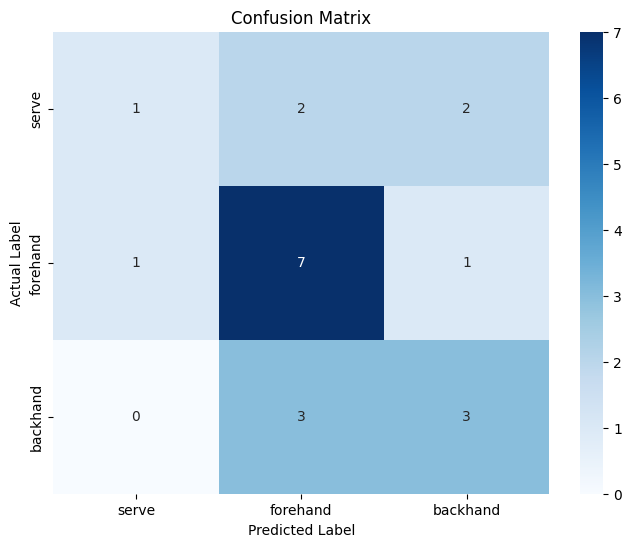

In [112]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get predictions on the validation set
y_pred = pickle_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# 2. Map labels back to names (Ensure order matches your loader)
label_map_rev = {0: 'serve', 1: 'forehand', 2: 'backhand'}
target_names = [label_map_rev[i] for i in range(len(label_map_rev))]

# 3. Print Text Report
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred_classes, target_names=target_names))

# 4. Plot Visual Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

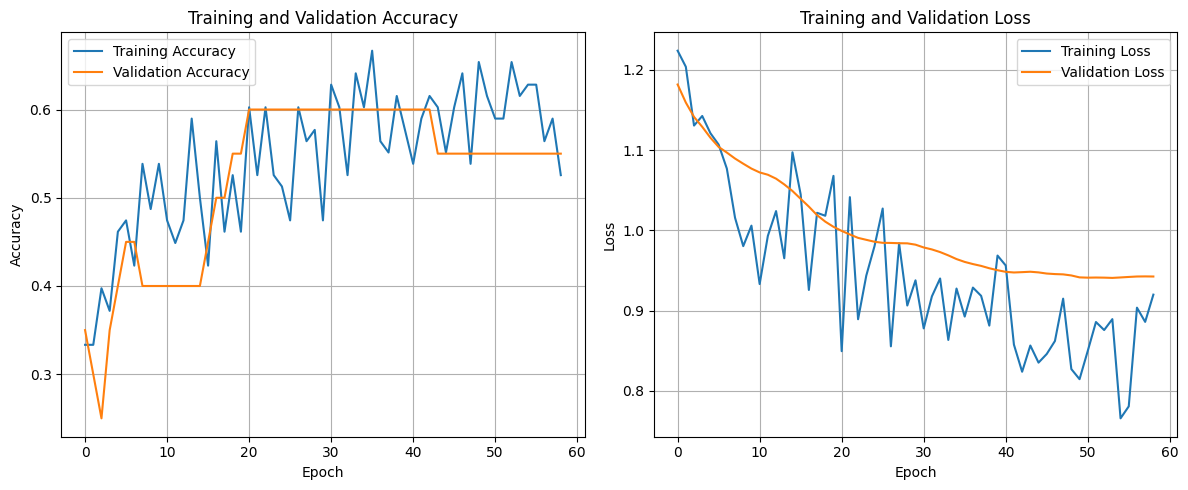

In [113]:
import matplotlib.pyplot as plt
import pandas as pd

# Combine history from both phases
history_df_phase1 = pd.DataFrame(history_phase1.history)
history_df_phase2 = pd.DataFrame(history_phase2.history)

# Reset index before concatenating to avoid duplicate indices
history_df_phase1 = history_df_phase1.reset_index(drop=True)
history_df_phase2 = history_df_phase2.reset_index(drop=True)

combined_history_df = pd.concat([history_df_phase1, history_df_phase2], ignore_index=True)

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(combined_history_df['accuracy'], label='Training Accuracy')
plt.plot(combined_history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(combined_history_df['loss'], label='Training Loss')
plt.plot(combined_history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [114]:
save_name = 'pickleball_model.keras'
pickle_model.save(save_name)
print(f"Model saved successfully as {save_name}")

Model saved successfully as pickleball_model.keras
